In [49]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorboard
from PIL import Image
import os
from datetime import datetime
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, Flatten

In [50]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [51]:
# get data
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(directory="data/ColorfulOriginal/", label_mode="categorical", batch_size=None, shuffle=False, image_size=(128,128), validation_split=0.1, subset="both", crop_to_aspect_ratio=True)

print(train_ds.class_names)
class_names = train_ds.class_names
normalizing_layer = tf.keras.layers.Rescaling(1./255)
flip_layer = tf.keras.layers.RandomFlip()
rotation_layer = tf.keras.layers.RandomRotation((-0.1,0.1))
#random_width_layer = tf.keras.layers.RandomWidth(0.1)
#random_height_layer = tf.keras.layers.RandomHeight(0.1)


def preprocess_train(data):

    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (flip_layer(x), y))
    data = data.map(lambda x,y: (rotation_layer(x), y))
    #data = data.map(lambda x,y: (random_width_layer(x), y))
    #data = data.map(lambda x,y: (random_height_layer(x), y))

    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))
    data = data.map(lambda image, label: ((((tf.expand_dims((image[:,:,0]/200 + 0.5), -1)), ((image[:,:,1:]/200) + 0.5))), label))
    #data = data.map(lambda image, label: ((((tf.expand_dims(image[:,:,0], -1))/100, ((image[:,:,1:]/256) + 0.5))), tf.one_hot(print_x(label), 120)))

    data = data.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

    return data

def preprocess_test(data):
    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))

    data = data.map(lambda image, label: (((tf.expand_dims((image[:,:,0]/200 + 0.5), -1), ((image[:,:,1:]/200) + 0.5))), label))

    data = data.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

    return data

train_data = preprocess_train(train_ds)
test_data = preprocess_test(test_ds)

print(train_data)

Found 721 files belonging to 20 classes.
Using 649 files for training.
Using 72 files for validation.
['Apple', 'Banana', 'Brinjal', 'Broccoli', 'CapsicumGreen', 'Carrot', 'Cherry', 'ChilliGreen', 'Corn', 'Cucumber', 'LadyFinger', 'Lemon', 'Orange', 'Peach', 'Pear', 'Plum', 'Pomegranate', 'Potato', 'Strawberry', 'Tomato']
<PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int32, name=None))>


tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)


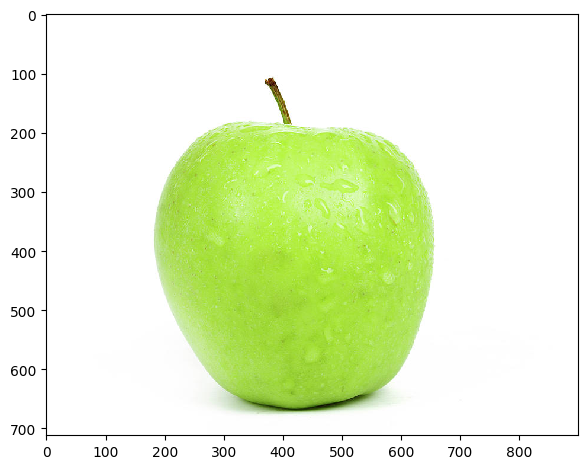

In [52]:
sample_image = imread("data/ColorfulOriginal/Apple/Apple1.jpg")/255
imshow(sample_image)

sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
#print(sample_image)
sample_image = tfio.experimental.color.rgb_to_lab(sample_image)
#print(sample_image)
print(tf.reduce_min(sample_image[0]), tf.reduce_max(sample_image[0]))
print(tf.reduce_min(sample_image[1]), tf.reduce_max(sample_image[1]))
print(tf.reduce_min(sample_image[2]), tf.reduce_max(sample_image[2]))

In [53]:
class Low_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_1 = tf.keras.layers.BatchNormalization()
        self.conv2 = Conv2D(128, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_2 = tf.keras.layers.BatchNormalization()
        self.conv3 = Conv2D(128, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_3 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(256, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_4 = tf.keras.layers.BatchNormalization() 
        self.conv5 = Conv2D(256, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_5 = tf.keras.layers.BatchNormalization() 
        self.conv6 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_6 = tf.keras.layers.BatchNormalization() 

    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv3(x)
        x = self.batchnorm_3(x, training)
        x = self.conv4(x)
        x = self.batchnorm_4(x, training)
        x = self.conv5(x)
        x = self.batchnorm_5(x, training)
        x = self.conv6(x)
        x = self.batchnorm_6(x, training)

        return x

In [54]:
class Mid_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(512, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_1 = tf.keras.layers.BatchNormalization()

        self.conv2 = Conv2D(256, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_2 = tf.keras.layers.BatchNormalization()


    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.batchnorm_1(x, training)

        x = self.conv2(x)
        x = self.batchnorm_2(x, training)

        return x

In [55]:
class High_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.max_pool1 = MaxPooling2D()
        self.batchnorm_1 = tf.keras.layers.BatchNormalization() 
        self.conv2 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_2 = tf.keras.layers.BatchNormalization() 
        self.conv3 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.max_pool2 = MaxPooling2D()

        self.batchnorm_3 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_4 = tf.keras.layers.BatchNormalization() 
        #self.flatten = Flatten()
        self.global_avg = GlobalAveragePooling2D()

        self.dense1 = Dense(1024, activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = Dense(512, activation="relu")
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.dense3 = Dense(256, activation="relu")
        self.dropout3 = tf.keras.layers.Dropout(0.2)

    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv3(x)
        x = self.max_pool2(x)
        x = self.batchnorm_3(x, training)
        x = self.conv4(x)
        x = self.batchnorm_4(x, training)
        #x = self.flatten(x)
        x = self.global_avg(x)
        x = self.dense1(x)
        x = self.dropout1(x, training)
        x = self.dense2(x)
        x = self.dropout2(x, training)
        x = self.dense3(x)
        x = self.dropout3(x, training)


        return x

In [56]:
class Classification_Layers(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(256, activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dense2 = Dense(20, activation="softmax")

    def __call__(self, x, training=False):
        x = self.dense1(x)
        x = self.dropout1(x, training)

        x = self.dense2(x)
        return x

In [57]:
class Fusion_Layer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        #32,256,256
        #

        self.repeat_layer = tf.keras.layers.RepeatVector(32*32)
        self.reshape = tf.keras.layers.Reshape(([32,32,256]))
        self.concat = tf.keras.layers.Concatenate(axis=3)
        self.conv = Conv2D(256, kernel_size=1,strides=1, activation="relu", padding="same")


    def __call__(self, mid_level, global_vector, training=False):
        x = self.repeat_layer(global_vector) 
        x = self.reshape(x)
        x = self.concat([mid_level, x]) 
        x = self.conv(x)

        return x 


In [58]:
class Colorization_Layers(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(128, 3, activation='relu', padding='same', strides=1) 
        self.upsampling1 = UpSampling2D(2)
        self.batchnorm_1 = tf.keras.layers.BatchNormalization() 
        self.conv2 = Conv2D(64, 3, activation='relu', padding='same', strides=1) 
        self.conv3 = Conv2D(64, 3, activation='relu', padding='same', strides=1)
        self.upsampling2 = UpSampling2D(2) 
        self.batchnorm_2 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(32, 3, activation='relu', padding='same', strides=1)
        self.conv5 = Conv2D(2, 3, activation='sigmoid', padding='same', strides=1) 
        self.upsampling3 = UpSampling2D(2) 


    def __call__(self, input, training=False):
        x = self.conv1(input)
        x = self.upsampling1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsampling2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv4(x)
        x = self.conv5(x)
        #x = self.upsampling3(x)

        return x


In [59]:
class Colorization_Network(tf.keras.Model):
    def __init__(self, low_level):
        super().__init__()
        self.low_level = low_level
        self.mid_level = Mid_Level_Features()
        self.fusion = Fusion_Layer()
        self.colorization = Colorization_Layers()


    def call(self, input, high_level_input, training=False):
        low = self.low_level(input, training)
        middle = self.mid_level(low, training)
        fused = self.fusion(middle, high_level_input, training)
        colored = self.colorization(fused, training)
        return colored



In [60]:
class Classification_Network(tf.keras.Model):
    def __init__(self, low_level):
        super().__init__()
        self.low_level = low_level 
        self.high_level = High_Level_Features()

        self.classification = Classification_Layers()




    def call(self, input, training=False):
        low = self.low_level(input, training)
        high = self.high_level(low, training)
        label = self.classification(high, training)
        return high, label

 


In [61]:
class Only_Colorization_Model(tf.keras.Model): 
    def __init__(self, optimizer, loss_function_color):
        super().__init__()
        self.low_level = Low_Level_Features()
        self.mid_level = Mid_Level_Features()
        self.colorization = Colorization_Layers()


        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_color"),
        ]

        self.optimizer = optimizer
        self.loss_function_color = loss_function_color

        

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()


    def call(self, input, training=False):
        low = self.low_level(input, training)
        middle = self.mid_level(low, training=training)
        colored = self.colorization(middle, training)
        return colored


    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as color_tape: 
            predicted_color = self(grey_image, training = True)
            loss_color = self.loss_function_color(color_image, predicted_color)

        gradients_color = color_tape.gradient(loss_color, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_color, self.trainable_variables))
        self.metrics[0].update_state(loss_color)  
        return predicted_color

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_color = self(grey_image, training = False)
        loss_color = self.loss_function_color(color_image, predicted_color)
        self.metrics[0].update_state(loss_color)  
        return predicted_color


In [62]:
class Only_Classification_Model(tf.keras.Model):
    def __init__(self, optimizer, loss_function_category):
        super().__init__()
        self.low_level = Low_Level_Features()        
        self.classification_model = Classification_Network(self.low_level)

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_category"),
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5,name="top-5-accuracy")]

        self.optimizer = optimizer
        self.loss_function_category = loss_function_category

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def call(self, input, training=False):
        _, label = self.classification_model(input, training)
        return label

    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as class_tape: 
            predicted_label = self(grey_image, training = True)
            loss_category = self.loss_function_category(label, predicted_label) / 200   

        gradients_category = class_tape.gradient(loss_category, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_category, self.trainable_variables))
        self.metrics[0].update_state(loss_category)  
        self.metrics[1].update_state(label, predicted_label)
        self.metrics[2].update_state(label, predicted_label)

        return predicted_label

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_label = self(grey_image, training = False)
        loss_category  = self.loss_function_category(label, predicted_label) / 200              
        self.metrics[0].update_state(loss_category)  
        self.metrics[1].update_state(label, predicted_label)
        self.metrics[2].update_state(label, predicted_label)

        return predicted_label


In [63]:
class Model(tf.keras.Model):
    def __init__(self, optimizer, loss_function_color, loss_function_category):
        super().__init__()
        self.low_level = Low_Level_Features()        

        self.colorization_model = Colorization_Network(self.low_level)
        self.classification_model = Classification_Network(self.low_level)

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_color"),
            tf.keras.metrics.Mean(name="loss_category"),
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5,name="top-5-accuracy")]

        self.optimizer = optimizer
        self.loss_function_color = loss_function_color
        self.loss_function_category = loss_function_category

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def call(self, input, training=False):
        high_level_info, label = self.classification_model(input, training)
        colored = self.colorization_model(input, high_level_info, training)
        return colored, label

    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as color_tape, tf.GradientTape() as class_tape: 
            predicted_color, predicted_label = self(grey_image, training = True)
            loss_color = self.loss_function_color(color_image, predicted_color)
            loss_category = self.loss_function_category(label, predicted_label) / 200

        gradients_color = color_tape.gradient(loss_color, self.colorization_model.trainable_variables)
        gradients_category = class_tape.gradient(loss_category, self.classification_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_color, self.colorization_model.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_category, self.classification_model.trainable_variables))
        self.metrics[0].update_state(loss_color)  
        self.metrics[1].update_state(loss_category)
        self.metrics[2].update_state(label, predicted_label)
        self.metrics[3].update_state(label, predicted_label)
        
        return predicted_color, predicted_label

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_color, predicted_label = self(grey_image, training = False)
        loss_color = self.loss_function_color(color_image, predicted_color)
        loss_category  = self.loss_function_category(label, predicted_label) / 200          
        self.metrics[0].update_state(loss_color)  
        self.metrics[1].update_state(loss_category)  
        self.metrics[2].update_state(label, predicted_label)
        self.metrics[3].update_state(label, predicted_label)

        return predicted_color, predicted_label


In [64]:
  
def visualize(predicted_color, predicted_label, data):
    images = data[0]
    labels = data[1]
    
    
    grey_images = images[0]
    grey_image = grey_images[0]
    color_images = images[1]
    color_image = color_images[0]
    label = labels[0]

    #print(tf.reduce_min(predicted_color), tf.reduce_max(predicted_color))
    #print(tf.reduce_min(color_image), tf.reduce_max(color_image))
    
    # manually clipping values, because Lab color space is weird
    predicted_color_lab_scaled = tf.clip_by_value(((predicted_color - [0.5, 0.5]) * [200, 200]), -100, 100)
    color_image_lab_scaled = tf.clip_by_value(((color_image - [0.5, 0.5]) * [200, 200]), -100, 100)
    greyscale =tf.squeeze((grey_image - [0.5]) * [200], axis=-1)

    #print(tf.reduce_min(predicted_color_lab_scaled), tf.reduce_max(predicted_color_lab_scaled))
    #print(tf.reduce_min(color_image_lab_scaled), tf.reduce_max(color_image_lab_scaled))
 

    rgb_prediction = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, predicted_color_lab_scaled[:,:,0], predicted_color_lab_scaled[:,:,1]],axis=-1))
    rgb_original = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, color_image_lab_scaled[:,:,0], color_image_lab_scaled[:,:,1]], axis=-1))

    #labels
    predicted_label = class_names[tf.argmax(predicted_label).numpy()]
    true_label = class_names[tf.argmax(label).numpy()]

    print(predicted_label, true_label)


    fig, ax = plt.subplots(1, 3, figsize = (18, 30))

    greyscale = ((greyscale/200) + 0.5) * 255
    ax[0].imshow(greyscale, cmap="gist_gray") 
    ax[0].axis('off')
    ax[0].set_title('greyscale')

    ax[1].imshow(rgb_prediction) 
    ax[1].axis('off')
    ax[1].set_title('pred: ' + predicted_label)
    
    ax[2].imshow(rgb_original) 
    ax[2].axis('off')
    ax[2].set_title('orig: ' + true_label)


    
    
   

In [65]:
# training loop

# log results with tensorboard 
# save model to be able to reuse it

def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color, predicted_label = model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            tf.summary.scalar(model.metrics[3].name, model.metrics[3].result(), step=epoch)

            
            
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Train)")
        print("Top-5-Accuracy: ", model.metrics[3].result().numpy(), "(Train)")


        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color, predicted_label = model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            tf.summary.scalar(model.metrics[3].name, model.metrics[3].result(), step=epoch)
                    
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Test)")
        print("Top-5-Accuracy: ", model.metrics[3].result().numpy(), "(Test)")







In [66]:
def training_loop_colorization(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color = model.test_step(data)
            last_data = data


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")


In [67]:
def training_loop_classification(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_label = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Train)")
        print("Top-5-Accuracy: ", model.metrics[2].result().numpy(), "(Train)")

        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_label = model.test_step(data)
            last_data = data

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Test)")
        print("Top-5-Accuracy: ", model.metrics[2].result().numpy(), "(Test)")


        print(class_names[tf.argmax(predicted_label[0]).numpy()], 
              class_names[tf.argmax(last_data[1][0]).numpy()])


In [ ]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

model00001= Model(optimizer=optimizer, loss_function_color=loss_function_color, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/train"
test_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop(model00001, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


 60%|██████    | 3/5 [00:00<00:00, 12.71it/s]

Strawberry Strawberry
Apple Tomato
Pomegranate Tomato
Strawberry Strawberry


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Strawberry Strawberry


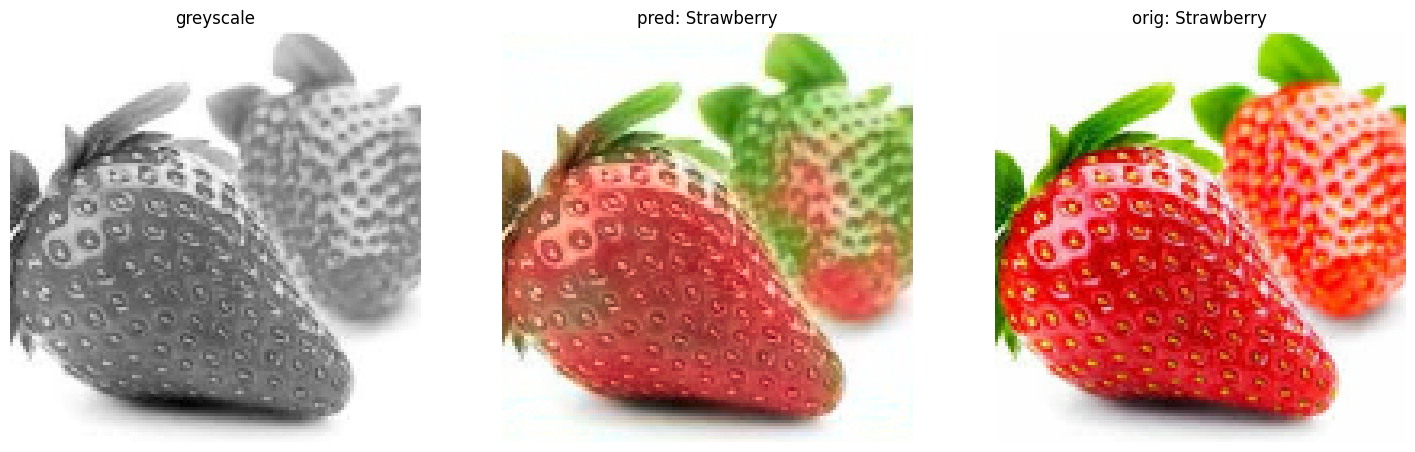

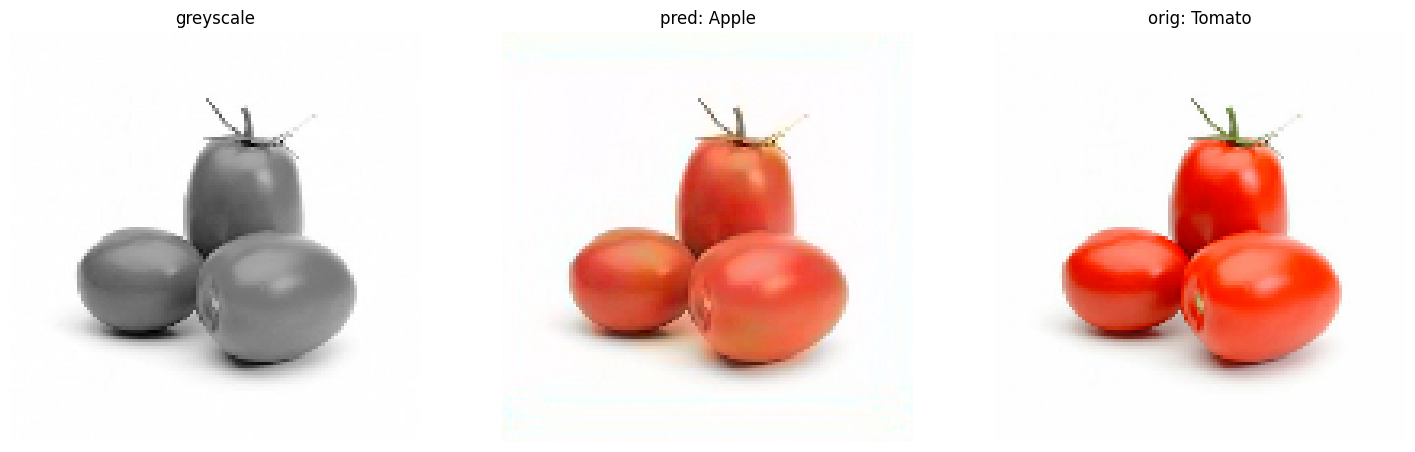

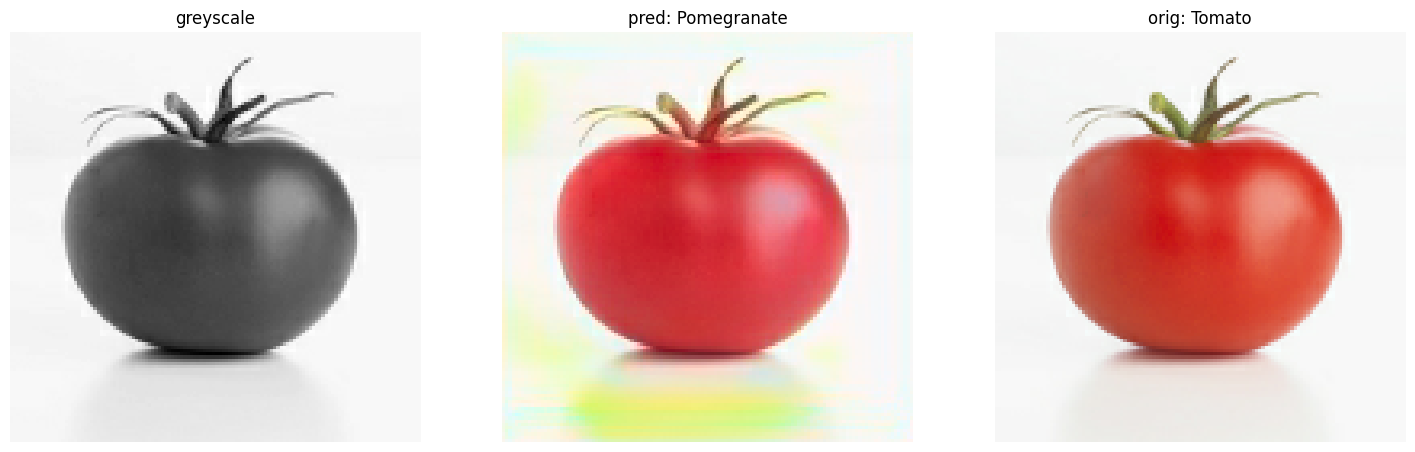

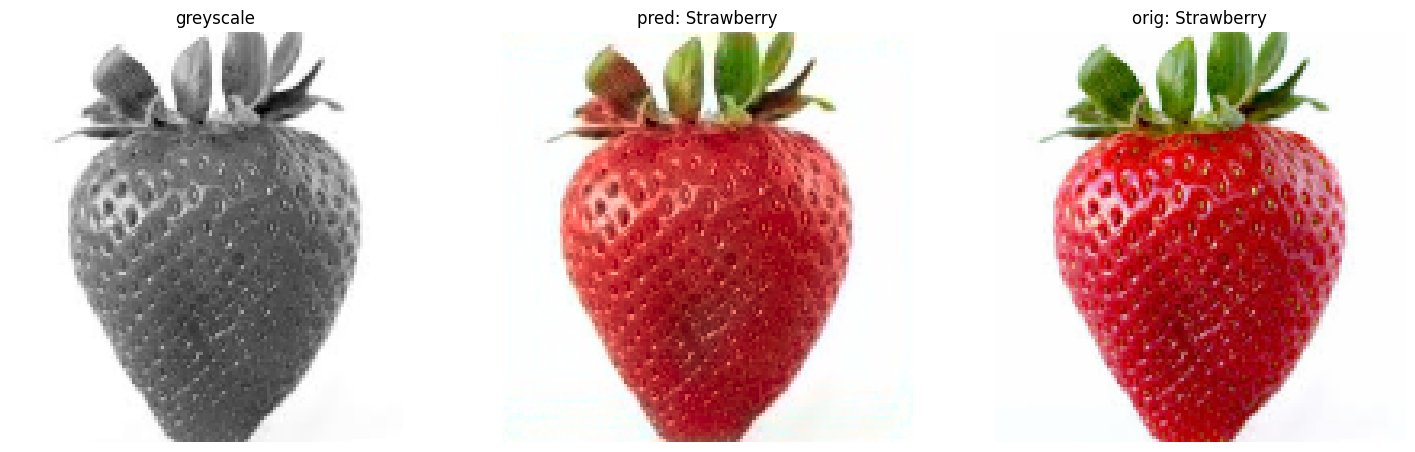

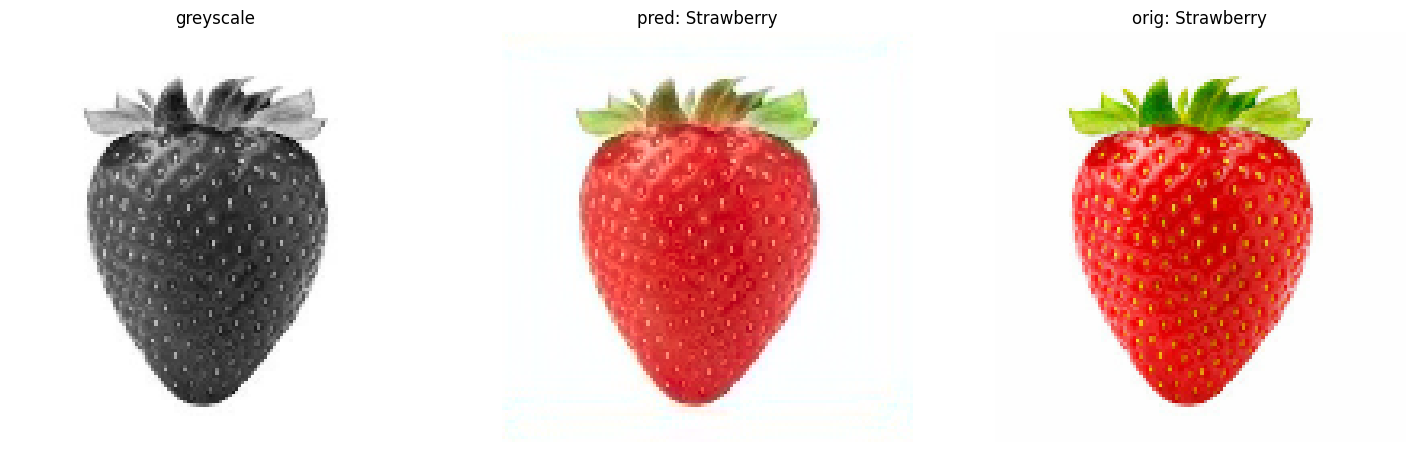

In [69]:
for data in tqdm(test_data, position=0, leave=True):
    predicted_color, predicted_label = model00001.test_step(data)

#
    if random.random() < 1:
        visualize(predicted_color[0], predicted_label[0], data)


In [70]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_classification = Only_Classification_Model(optimizer=optimizer, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/classification/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/classification/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop_classification(only_classification, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 41/41 [00:03<00:00, 12.38it/s]


Epoch:  1
Loss Category:  0.015078791 (Train)
Accuracy:  0.046224963 (Train)
Top-5-Accuracy:  0.2403698 (Train)


100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


Loss Category:  0.014692308 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Tomato


100%|██████████| 41/41 [00:02<00:00, 16.68it/s]


Epoch:  2
Loss Category:  0.014792399 (Train)
Accuracy:  0.08012327 (Train)
Top-5-Accuracy:  0.33281973 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.84it/s]


Loss Category:  0.0146744475 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Tomato


100%|██████████| 41/41 [00:02<00:00, 17.69it/s]


Epoch:  3
Loss Category:  0.01464214 (Train)
Accuracy:  0.08012327 (Train)
Top-5-Accuracy:  0.34822804 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.47it/s]


Loss Category:  0.014794985 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Tomato


100%|██████████| 41/41 [00:02<00:00, 17.39it/s]


Epoch:  4
Loss Category:  0.014334544 (Train)
Accuracy:  0.1201849 (Train)
Top-5-Accuracy:  0.4175655 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.93it/s]


Loss Category:  0.0150554385 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.54it/s]


Epoch:  5
Loss Category:  0.014040345 (Train)
Accuracy:  0.1587057 (Train)
Top-5-Accuracy:  0.4807396 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.40it/s]


Loss Category:  0.015491794 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Tomato


100%|██████████| 41/41 [00:02<00:00, 17.78it/s]


Epoch:  6
Loss Category:  0.013994059 (Train)
Accuracy:  0.1540832 (Train)
Top-5-Accuracy:  0.4899846 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.79it/s]


Loss Category:  0.015613623 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6666667 (Test)
Banana Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.15it/s]


Epoch:  7
Loss Category:  0.013787616 (Train)
Accuracy:  0.16486903 (Train)
Top-5-Accuracy:  0.4915254 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.22it/s]


Loss Category:  0.016160097 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.6388889 (Test)
Banana Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.93it/s]


Epoch:  8
Loss Category:  0.013614714 (Train)
Accuracy:  0.16178736 (Train)
Top-5-Accuracy:  0.5238829 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.15it/s]


Loss Category:  0.01617446 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.5972222 (Test)
Lemon Tomato


100%|██████████| 41/41 [00:02<00:00, 17.27it/s]


Epoch:  9
Loss Category:  0.0135744605 (Train)
Accuracy:  0.16486903 (Train)
Top-5-Accuracy:  0.5439137 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.02it/s]


Loss Category:  0.016674366 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.125 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 17.48it/s]


Epoch:  10
Loss Category:  0.013171297 (Train)
Accuracy:  0.201849 (Train)
Top-5-Accuracy:  0.58243454 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.73it/s]


Loss Category:  0.017337082 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.055555556 (Test)
Lemon Tomato


100%|██████████| 41/41 [00:02<00:00, 17.61it/s]


Epoch:  11
Loss Category:  0.013174739 (Train)
Accuracy:  0.18644068 (Train)
Top-5-Accuracy:  0.5947612 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.18it/s]


Loss Category:  0.017919805 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Orange Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.64it/s]


Epoch:  12
Loss Category:  0.012929237 (Train)
Accuracy:  0.22033899 (Train)
Top-5-Accuracy:  0.6348228 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.45it/s]


Loss Category:  0.017835382 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 17.78it/s]


Epoch:  13
Loss Category:  0.012784059 (Train)
Accuracy:  0.22342065 (Train)
Top-5-Accuracy:  0.63328195 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.22it/s]


Loss Category:  0.01757 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 17.45it/s]


Epoch:  14
Loss Category:  0.012695513 (Train)
Accuracy:  0.23574731 (Train)
Top-5-Accuracy:  0.6394453 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.39it/s]


Loss Category:  0.017768541 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Orange Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.62it/s]


Epoch:  15
Loss Category:  0.012377356 (Train)
Accuracy:  0.24191064 (Train)
Top-5-Accuracy:  0.6563945 (Train)


100%|██████████| 5/5 [00:00<00:00, 34.52it/s]


Loss Category:  0.018251695 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 17.55it/s]


Epoch:  16
Loss Category:  0.012391652 (Train)
Accuracy:  0.2449923 (Train)
Top-5-Accuracy:  0.65793526 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.45it/s]


Loss Category:  0.017582692 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.83it/s]


Epoch:  17
Loss Category:  0.012278327 (Train)
Accuracy:  0.24961479 (Train)
Top-5-Accuracy:  0.6979969 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.63it/s]


Loss Category:  0.018529333 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 17.61it/s]


Epoch:  18
Loss Category:  0.011937748 (Train)
Accuracy:  0.2650231 (Train)
Top-5-Accuracy:  0.7103236 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.05it/s]


Loss Category:  0.018954482 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.77it/s]


Epoch:  19
Loss Category:  0.0119099375 (Train)
Accuracy:  0.28659475 (Train)
Top-5-Accuracy:  0.69491524 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.39it/s]


Loss Category:  0.019184282 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.99it/s]


Epoch:  20
Loss Category:  0.0115573825 (Train)
Accuracy:  0.30354393 (Train)
Top-5-Accuracy:  0.7180277 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.97it/s]


Loss Category:  0.01967633 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Tomato


100%|██████████| 41/41 [00:02<00:00, 17.44it/s]


Epoch:  21
Loss Category:  0.011881382 (Train)
Accuracy:  0.26656395 (Train)
Top-5-Accuracy:  0.6918336 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.57it/s]


Loss Category:  0.021111349 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.36it/s]


Epoch:  22
Loss Category:  0.0116903465 (Train)
Accuracy:  0.3020031 (Train)
Top-5-Accuracy:  0.70878273 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.71it/s]


Loss Category:  0.020440722 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.82it/s]


Epoch:  23
Loss Category:  0.011514072 (Train)
Accuracy:  0.28043142 (Train)
Top-5-Accuracy:  0.7395994 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.83it/s]


Loss Category:  0.020698763 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Cherry Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.77it/s]


Epoch:  24
Loss Category:  0.011297395 (Train)
Accuracy:  0.31587058 (Train)
Top-5-Accuracy:  0.74730355 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.45it/s]


Loss Category:  0.020826453 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.70it/s]


Epoch:  25
Loss Category:  0.011289819 (Train)
Accuracy:  0.30046225 (Train)
Top-5-Accuracy:  0.75346684 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.43it/s]


Loss Category:  0.022148658 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.44it/s]


Epoch:  26
Loss Category:  0.011110579 (Train)
Accuracy:  0.34052387 (Train)
Top-5-Accuracy:  0.7395994 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.34it/s]


Loss Category:  0.02109902 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.91it/s]


Epoch:  27
Loss Category:  0.01100828 (Train)
Accuracy:  0.3713405 (Train)
Top-5-Accuracy:  0.7488444 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.86it/s]


Loss Category:  0.022584772 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.07it/s]


Epoch:  28
Loss Category:  0.01098247 (Train)
Accuracy:  0.3174114 (Train)
Top-5-Accuracy:  0.79198766 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.79it/s]


Loss Category:  0.022169808 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.49it/s]


Epoch:  29
Loss Category:  0.010902122 (Train)
Accuracy:  0.3220339 (Train)
Top-5-Accuracy:  0.7734977 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.03it/s]


Loss Category:  0.022503844 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Tomato


100%|██████████| 41/41 [00:02<00:00, 17.43it/s]


Epoch:  30
Loss Category:  0.010636995 (Train)
Accuracy:  0.3081664 (Train)
Top-5-Accuracy:  0.76733434 (Train)


100%|██████████| 5/5 [00:00<00:00, 43.71it/s]


Loss Category:  0.023265233 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.20it/s]


Epoch:  31
Loss Category:  0.0105296895 (Train)
Accuracy:  0.34052387 (Train)
Top-5-Accuracy:  0.7935285 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.23it/s]


Loss Category:  0.023247974 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.53it/s]


Epoch:  32
Loss Category:  0.010710771 (Train)
Accuracy:  0.35130972 (Train)
Top-5-Accuracy:  0.76117104 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.56it/s]


Loss Category:  0.022396768 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.80it/s]


Epoch:  33
Loss Category:  0.010300045 (Train)
Accuracy:  0.35439137 (Train)
Top-5-Accuracy:  0.78890604 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.65it/s]


Loss Category:  0.023689423 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.64it/s]


Epoch:  34
Loss Category:  0.01032856 (Train)
Accuracy:  0.3312789 (Train)
Top-5-Accuracy:  0.79506934 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.44it/s]


Loss Category:  0.023431296 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Tomato


100%|██████████| 41/41 [00:02<00:00, 17.68it/s]


Epoch:  35
Loss Category:  0.010141906 (Train)
Accuracy:  0.37288135 (Train)
Top-5-Accuracy:  0.8212635 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.53it/s]


Loss Category:  0.02484056 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.88it/s]


Epoch:  36
Loss Category:  0.010214446 (Train)
Accuracy:  0.3713405 (Train)
Top-5-Accuracy:  0.82280433 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.71it/s]


Loss Category:  0.024167761 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.70it/s]


Epoch:  37
Loss Category:  0.009928356 (Train)
Accuracy:  0.3744222 (Train)
Top-5-Accuracy:  0.8212635 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.71it/s]


Loss Category:  0.024266254 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.42it/s]


Epoch:  38
Loss Category:  0.009971738 (Train)
Accuracy:  0.39445302 (Train)
Top-5-Accuracy:  0.8120185 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.40it/s]


Loss Category:  0.025248757 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.23it/s]


Epoch:  39
Loss Category:  0.009542105 (Train)
Accuracy:  0.39753467 (Train)
Top-5-Accuracy:  0.83359015 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.96it/s]


Loss Category:  0.024950346 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.96it/s]


Epoch:  40
Loss Category:  0.00976169 (Train)
Accuracy:  0.39599383 (Train)
Top-5-Accuracy:  0.81972265 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.41it/s]


Loss Category:  0.024003113 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 17.09it/s]


Epoch:  41
Loss Category:  0.009431701 (Train)
Accuracy:  0.42372882 (Train)
Top-5-Accuracy:  0.8366718 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.66it/s]


Loss Category:  0.023837032 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.92it/s]


Epoch:  42
Loss Category:  0.009591981 (Train)
Accuracy:  0.37904468 (Train)
Top-5-Accuracy:  0.86132514 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.46it/s]


Loss Category:  0.027142549 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Cucumber Tomato


100%|██████████| 41/41 [00:02<00:00, 16.81it/s]


Epoch:  43
Loss Category:  0.009395234 (Train)
Accuracy:  0.42218798 (Train)
Top-5-Accuracy:  0.8412943 (Train)


100%|██████████| 5/5 [00:00<00:00, 35.21it/s]


Loss Category:  0.023399279 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.69it/s]


Epoch:  44
Loss Category:  0.00927362 (Train)
Accuracy:  0.40523884 (Train)
Top-5-Accuracy:  0.8428351 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.37it/s]


Loss Category:  0.029139807 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.67it/s]


Epoch:  45
Loss Category:  0.009267865 (Train)
Accuracy:  0.42989215 (Train)
Top-5-Accuracy:  0.8628659 (Train)


100%|██████████| 5/5 [00:00<00:00, 34.30it/s]


Loss Category:  0.026243687 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.74it/s]


Epoch:  46
Loss Category:  0.009345577 (Train)
Accuracy:  0.3990755 (Train)
Top-5-Accuracy:  0.8428351 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.55it/s]


Loss Category:  0.027223904 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.26it/s]


Epoch:  47
Loss Category:  0.008882674 (Train)
Accuracy:  0.4622496 (Train)
Top-5-Accuracy:  0.86440676 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.08it/s]


Loss Category:  0.027244028 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.16it/s]


Epoch:  48
Loss Category:  0.008620317 (Train)
Accuracy:  0.45916796 (Train)
Top-5-Accuracy:  0.8690293 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.29it/s]


Loss Category:  0.030750144 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.19it/s]


Epoch:  49
Loss Category:  0.009094572 (Train)
Accuracy:  0.40677965 (Train)
Top-5-Accuracy:  0.8659476 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.87it/s]


Loss Category:  0.027588224 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.52it/s]


Epoch:  50
Loss Category:  0.0088254465 (Train)
Accuracy:  0.42681047 (Train)
Top-5-Accuracy:  0.86748844 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.95it/s]


Loss Category:  0.02560098 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 17.85it/s]


Epoch:  51
Loss Category:  0.008834958 (Train)
Accuracy:  0.41602466 (Train)
Top-5-Accuracy:  0.8751926 (Train)


100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Loss Category:  0.02878647 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.69it/s]


Epoch:  52
Loss Category:  0.008691805 (Train)
Accuracy:  0.45762712 (Train)
Top-5-Accuracy:  0.8659476 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.68it/s]


Loss Category:  0.026672095 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.33it/s]


Epoch:  53
Loss Category:  0.008506565 (Train)
Accuracy:  0.47149462 (Train)
Top-5-Accuracy:  0.8936826 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.89it/s]


Loss Category:  0.028485974 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.41it/s]


Epoch:  54
Loss Category:  0.008858977 (Train)
Accuracy:  0.4329738 (Train)
Top-5-Accuracy:  0.8844376 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.21it/s]


Loss Category:  0.02667588 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.14it/s]


Epoch:  55
Loss Category:  0.008386885 (Train)
Accuracy:  0.47919875 (Train)
Top-5-Accuracy:  0.87827426 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.21it/s]


Loss Category:  0.027286116 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.82it/s]


Epoch:  56
Loss Category:  0.008430087 (Train)
Accuracy:  0.45300463 (Train)
Top-5-Accuracy:  0.8751926 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.58it/s]


Loss Category:  0.026373839 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.67it/s]


Epoch:  57
Loss Category:  0.008228466 (Train)
Accuracy:  0.46995378 (Train)
Top-5-Accuracy:  0.8859784 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.32it/s]


Loss Category:  0.026019875 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.84it/s]


Epoch:  58
Loss Category:  0.008075671 (Train)
Accuracy:  0.48536208 (Train)
Top-5-Accuracy:  0.89214176 (Train)


100%|██████████| 5/5 [00:00<00:00, 43.27it/s]


Loss Category:  0.030195732 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.72it/s]


Epoch:  59
Loss Category:  0.007849473 (Train)
Accuracy:  0.4915254 (Train)
Top-5-Accuracy:  0.8998459 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.46it/s]


Loss Category:  0.02770483 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.39it/s]


Epoch:  60
Loss Category:  0.008120637 (Train)
Accuracy:  0.49306625 (Train)
Top-5-Accuracy:  0.88135594 (Train)


100%|██████████| 5/5 [00:00<00:00, 35.63it/s]


Loss Category:  0.028344506 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.41it/s]


Epoch:  61
Loss Category:  0.007945826 (Train)
Accuracy:  0.49614793 (Train)
Top-5-Accuracy:  0.88751924 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.24it/s]


Loss Category:  0.028808832 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.28it/s]


Epoch:  62
Loss Category:  0.007962674 (Train)
Accuracy:  0.4761171 (Train)
Top-5-Accuracy:  0.89522344 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.52it/s]


Loss Category:  0.029612765 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.59it/s]


Epoch:  63
Loss Category:  0.0077379607 (Train)
Accuracy:  0.49768874 (Train)
Top-5-Accuracy:  0.8890601 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.76it/s]


Loss Category:  0.03240084 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 17.15it/s]


Epoch:  64
Loss Category:  0.0077756993 (Train)
Accuracy:  0.49768874 (Train)
Top-5-Accuracy:  0.9029276 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.32it/s]


Loss Category:  0.026729852 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.94it/s]


Epoch:  65
Loss Category:  0.007503324 (Train)
Accuracy:  0.5146379 (Train)
Top-5-Accuracy:  0.8998459 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.07it/s]


Loss Category:  0.027555972 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Apple Tomato


100%|██████████| 41/41 [00:02<00:00, 16.09it/s]


Epoch:  66
Loss Category:  0.007592721 (Train)
Accuracy:  0.48382127 (Train)
Top-5-Accuracy:  0.90138674 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.24it/s]


Loss Category:  0.026241997 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Cucumber Tomato


100%|██████████| 41/41 [00:02<00:00, 17.19it/s]


Epoch:  67
Loss Category:  0.007358967 (Train)
Accuracy:  0.53466874 (Train)
Top-5-Accuracy:  0.9029276 (Train)


100%|██████████| 5/5 [00:00<00:00, 44.90it/s]


Loss Category:  0.026032966 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.36it/s]


Epoch:  68
Loss Category:  0.00761511 (Train)
Accuracy:  0.51309705 (Train)
Top-5-Accuracy:  0.9075501 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.43it/s]


Loss Category:  0.026368821 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 17.02it/s]


Epoch:  69
Loss Category:  0.007462008 (Train)
Accuracy:  0.49614793 (Train)
Top-5-Accuracy:  0.9306626 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.58it/s]


Loss Category:  0.030247426 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Strawberry


100%|██████████| 41/41 [00:02<00:00, 17.30it/s]


Epoch:  70
Loss Category:  0.007232539 (Train)
Accuracy:  0.53158706 (Train)
Top-5-Accuracy:  0.91217256 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.30it/s]


Loss Category:  0.02828685 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.36it/s]


Epoch:  71
Loss Category:  0.0076494087 (Train)
Accuracy:  0.51155627 (Train)
Top-5-Accuracy:  0.9029276 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.77it/s]


Loss Category:  0.031348445 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.55it/s]


Epoch:  72
Loss Category:  0.007304335 (Train)
Accuracy:  0.54083204 (Train)
Top-5-Accuracy:  0.91217256 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.88it/s]


Loss Category:  0.027391803 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.51it/s]


Epoch:  73
Loss Category:  0.006972957 (Train)
Accuracy:  0.54083204 (Train)
Top-5-Accuracy:  0.9137134 (Train)


100%|██████████| 5/5 [00:00<00:00, 35.19it/s]


Loss Category:  0.028601294 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.055555556 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.28it/s]


Epoch:  74
Loss Category:  0.0069232075 (Train)
Accuracy:  0.5762712 (Train)
Top-5-Accuracy:  0.9337442 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.69it/s]


Loss Category:  0.030307967 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.041666668 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.63it/s]


Epoch:  75
Loss Category:  0.0071152654 (Train)
Accuracy:  0.5161787 (Train)
Top-5-Accuracy:  0.9337442 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.18it/s]


Loss Category:  0.03040566 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.013888889 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.52it/s]


Epoch:  76
Loss Category:  0.006979645 (Train)
Accuracy:  0.53466874 (Train)
Top-5-Accuracy:  0.9167951 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.96it/s]


Loss Category:  0.028099388 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.0 (Test)
Pomegranate Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.60it/s]


Epoch:  77
Loss Category:  0.007253933 (Train)
Accuracy:  0.53775036 (Train)
Top-5-Accuracy:  0.9044684 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.67it/s]


Loss Category:  0.028784748 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.041666668 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.60it/s]


Epoch:  78
Loss Category:  0.0072987997 (Train)
Accuracy:  0.5146379 (Train)
Top-5-Accuracy:  0.92604005 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.81it/s]


Loss Category:  0.030249694 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.083333336 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.50it/s]


Epoch:  79
Loss Category:  0.006556396 (Train)
Accuracy:  0.5701079 (Train)
Top-5-Accuracy:  0.9337442 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.39it/s]


Loss Category:  0.031760924 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.16666667 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.41it/s]


Epoch:  80
Loss Category:  0.0069290167 (Train)
Accuracy:  0.53775036 (Train)
Top-5-Accuracy:  0.9229584 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.14it/s]


Loss Category:  0.02677862 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.22222222 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.91it/s]


Epoch:  81
Loss Category:  0.006717915 (Train)
Accuracy:  0.5731895 (Train)
Top-5-Accuracy:  0.92912173 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.22it/s]


Loss Category:  0.02584436 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.15277778 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 16.53it/s]


Epoch:  82
Loss Category:  0.0065544792 (Train)
Accuracy:  0.5762712 (Train)
Top-5-Accuracy:  0.93528503 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.31it/s]


Loss Category:  0.031144887 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.19444445 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.58it/s]


Epoch:  83
Loss Category:  0.006703365 (Train)
Accuracy:  0.56548536 (Train)
Top-5-Accuracy:  0.9414484 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.43it/s]


Loss Category:  0.031588595 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.125 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.48it/s]


Epoch:  84
Loss Category:  0.006563369 (Train)
Accuracy:  0.57473034 (Train)
Top-5-Accuracy:  0.9214176 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.26it/s]


Loss Category:  0.030684937 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2638889 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.56it/s]


Epoch:  85
Loss Category:  0.0062477146 (Train)
Accuracy:  0.605547 (Train)
Top-5-Accuracy:  0.9368259 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.69it/s]


Loss Category:  0.030777693 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.20833333 (Test)
Cherry Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.16it/s]


Epoch:  86
Loss Category:  0.006462297 (Train)
Accuracy:  0.58551615 (Train)
Top-5-Accuracy:  0.9167951 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.31it/s]


Loss Category:  0.026104435 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2361111 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.66it/s]


Epoch:  87
Loss Category:  0.006496664 (Train)
Accuracy:  0.57935286 (Train)
Top-5-Accuracy:  0.9414484 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.86it/s]


Loss Category:  0.029804641 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.20833333 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.39it/s]


Epoch:  88
Loss Category:  0.006022091 (Train)
Accuracy:  0.61787367 (Train)
Top-5-Accuracy:  0.9522342 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.54it/s]


Loss Category:  0.033154093 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2361111 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.38it/s]


Epoch:  89
Loss Category:  0.006261639 (Train)
Accuracy:  0.6101695 (Train)
Top-5-Accuracy:  0.94607085 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.73it/s]


Loss Category:  0.029678324 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.16666667 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 16.74it/s]


Epoch:  90
Loss Category:  0.006382526 (Train)
Accuracy:  0.5808937 (Train)
Top-5-Accuracy:  0.93528503 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.14it/s]


Loss Category:  0.032405414 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.22222222 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.75it/s]


Epoch:  91
Loss Category:  0.006072668 (Train)
Accuracy:  0.58859783 (Train)
Top-5-Accuracy:  0.9337442 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.46it/s]


Loss Category:  0.030042877 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 16.56it/s]


Epoch:  92
Loss Category:  0.005946452 (Train)
Accuracy:  0.6194145 (Train)
Top-5-Accuracy:  0.95069337 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.16it/s]


Loss Category:  0.031128446 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.27it/s]


Epoch:  93
Loss Category:  0.006188132 (Train)
Accuracy:  0.5762712 (Train)
Top-5-Accuracy:  0.94298923 (Train)


100%|██████████| 5/5 [00:00<00:00, 36.31it/s]


Loss Category:  0.03168305 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.25 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 17.02it/s]


Epoch:  94
Loss Category:  0.0062140385 (Train)
Accuracy:  0.59630203 (Train)
Top-5-Accuracy:  0.9414484 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.43it/s]


Loss Category:  0.027620945 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.30555555 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.80it/s]


Epoch:  95
Loss Category:  0.0059163654 (Train)
Accuracy:  0.61787367 (Train)
Top-5-Accuracy:  0.94607085 (Train)


100%|██████████| 5/5 [00:00<00:00, 39.69it/s]


Loss Category:  0.029717037 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


Epoch:  96
Loss Category:  0.005939728 (Train)
Accuracy:  0.61787367 (Train)
Top-5-Accuracy:  0.9383667 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.97it/s]


Loss Category:  0.028734233 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2638889 (Test)
Carrot Tomato


100%|██████████| 41/41 [00:02<00:00, 16.97it/s]


Epoch:  97
Loss Category:  0.0054627457 (Train)
Accuracy:  0.6394453 (Train)
Top-5-Accuracy:  0.96302 (Train)


100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Loss Category:  0.028869728 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)
Pomegranate Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.51it/s]


Epoch:  98
Loss Category:  0.0058365413 (Train)
Accuracy:  0.6009245 (Train)
Top-5-Accuracy:  0.95377505 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.31it/s]


Loss Category:  0.026680842 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 16.96it/s]


Epoch:  99
Loss Category:  0.00558699 (Train)
Accuracy:  0.62711865 (Train)
Top-5-Accuracy:  0.94607085 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.05it/s]


Loss Category:  0.030596834 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.25 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.77it/s]


Epoch:  100
Loss Category:  0.0055895303 (Train)
Accuracy:  0.63328195 (Train)
Top-5-Accuracy:  0.95377505 (Train)


100%|██████████| 5/5 [00:00<00:00, 41.16it/s]


Loss Category:  0.02826218 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2777778 (Test)
Orange Tomato


100%|██████████| 41/41 [00:02<00:00, 16.82it/s]


Epoch:  101
Loss Category:  0.005695452 (Train)
Accuracy:  0.6286595 (Train)
Top-5-Accuracy:  0.95377505 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.89it/s]


Loss Category:  0.030320227 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.30555555 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.91it/s]


Epoch:  102
Loss Category:  0.005837946 (Train)
Accuracy:  0.614792 (Train)
Top-5-Accuracy:  0.9414484 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.36it/s]


Loss Category:  0.02742213 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.2638889 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.74it/s]


Epoch:  103
Loss Category:  0.005187524 (Train)
Accuracy:  0.6440678 (Train)
Top-5-Accuracy:  0.9661017 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.72it/s]


Loss Category:  0.0301313 (Test)
Accuracy:  0.013888889 (Test)
Top-5-Accuracy:  0.2777778 (Test)
Cherry Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.45it/s]


Epoch:  104
Loss Category:  0.005279163 (Train)
Accuracy:  0.63790447 (Train)
Top-5-Accuracy:  0.94607085 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.58it/s]


Loss Category:  0.028815702 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.83it/s]


Epoch:  105
Loss Category:  0.005177093 (Train)
Accuracy:  0.6640986 (Train)
Top-5-Accuracy:  0.9614792 (Train)


100%|██████████| 5/5 [00:00<00:00, 37.39it/s]


Loss Category:  0.032666482 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)
Broccoli Strawberry


100%|██████████| 41/41 [00:02<00:00, 16.98it/s]


Epoch:  106
Loss Category:  0.005362616 (Train)
Accuracy:  0.65485364 (Train)
Top-5-Accuracy:  0.9614792 (Train)


100%|██████████| 5/5 [00:00<00:00, 38.48it/s]


Loss Category:  0.031245759 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.2777778 (Test)
Pomegranate Tomato


100%|██████████| 41/41 [00:02<00:00, 16.53it/s]


Epoch:  107
Loss Category:  0.005133348 (Train)
Accuracy:  0.6671803 (Train)
Top-5-Accuracy:  0.9568567 (Train)


100%|██████████| 5/5 [00:00<00:00, 42.34it/s]


Loss Category:  0.028884327 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.31944445 (Test)
CapsicumGreen Tomato


100%|██████████| 41/41 [00:02<00:00, 16.96it/s]


Epoch:  108
Loss Category:  0.0051526134 (Train)
Accuracy:  0.66101694 (Train)
Top-5-Accuracy:  0.97072417 (Train)


100%|██████████| 5/5 [00:00<00:00, 40.55it/s]


Loss Category:  0.028839499 (Test)
Accuracy:  0.0 (Test)
Top-5-Accuracy:  0.29166666 (Test)
CapsicumGreen Tomato


 32%|███▏      | 13/41 [00:01<00:01, 15.20it/s]

In [ ]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_colorization = Only_Colorization_Model(optimizer=optimizer, loss_function_color=loss_function_color)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/colorization/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/colorization/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop_colorization(only_colorization, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


100%|██████████| 5/5 [00:00<00:00, 22.06it/s]

Tomato Tomato
Strawberry Strawberry
Tomato Tomato
Tomato Tomato
Tomato Tomato


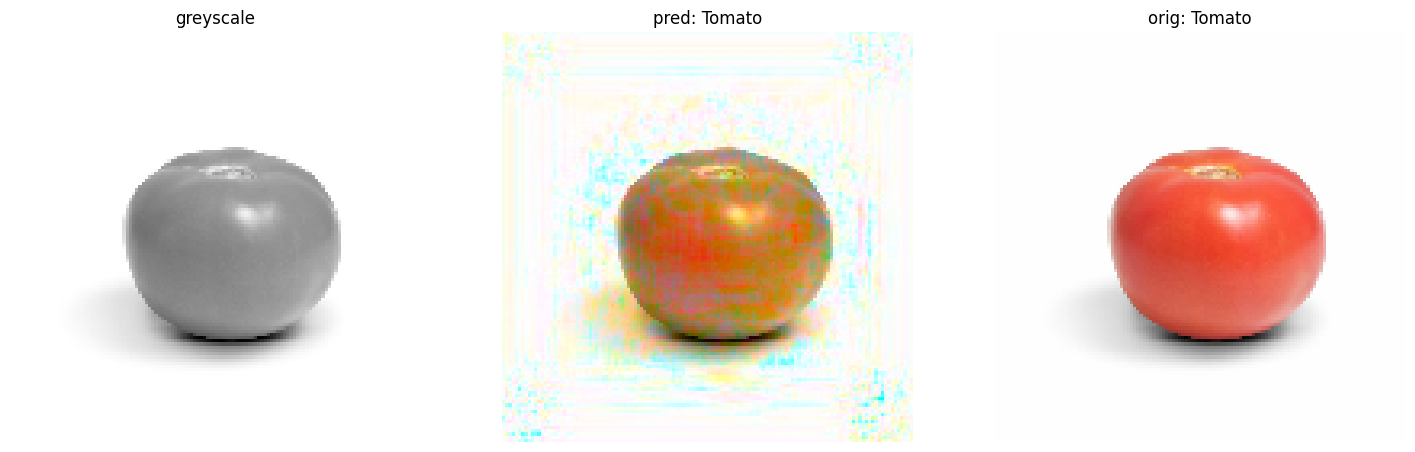

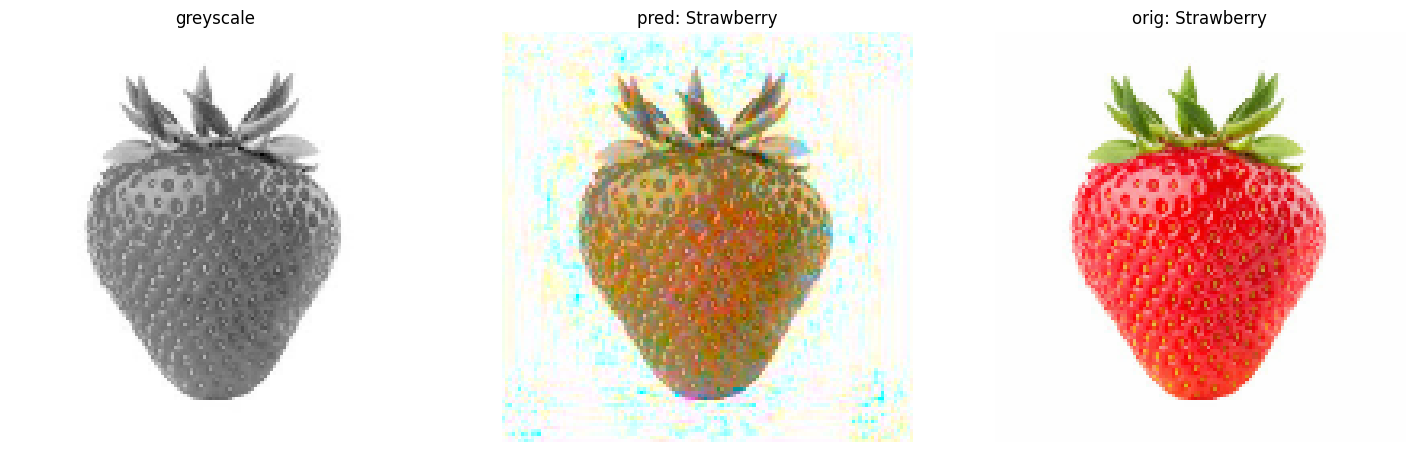

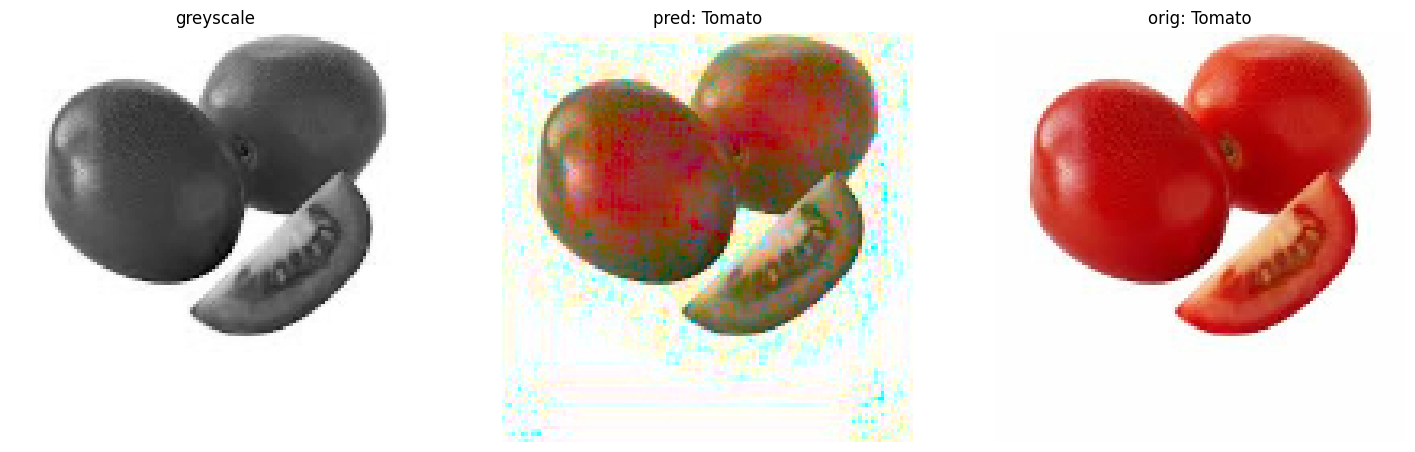

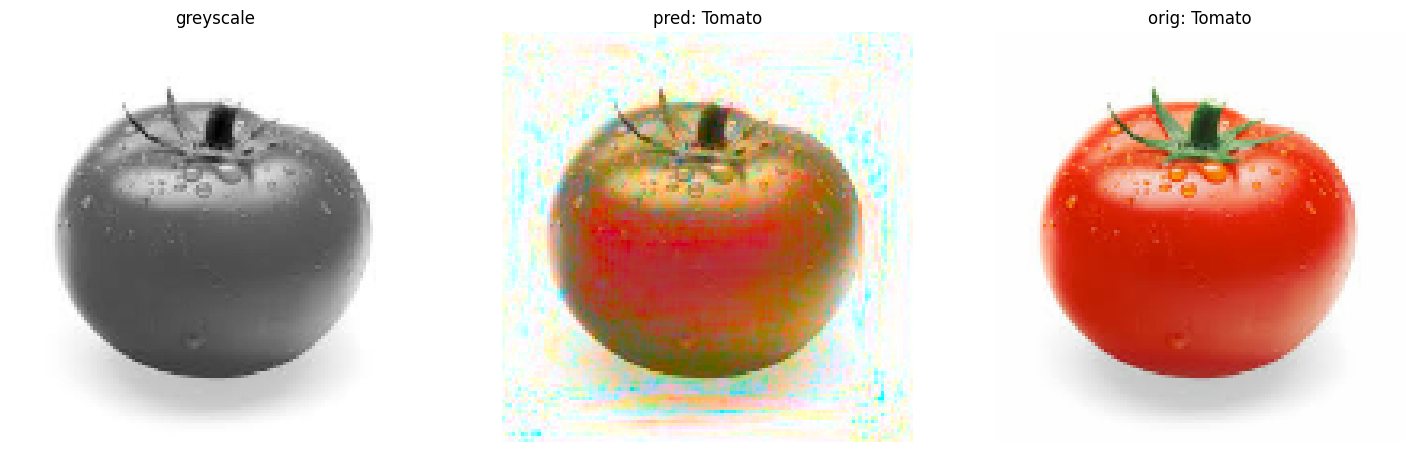

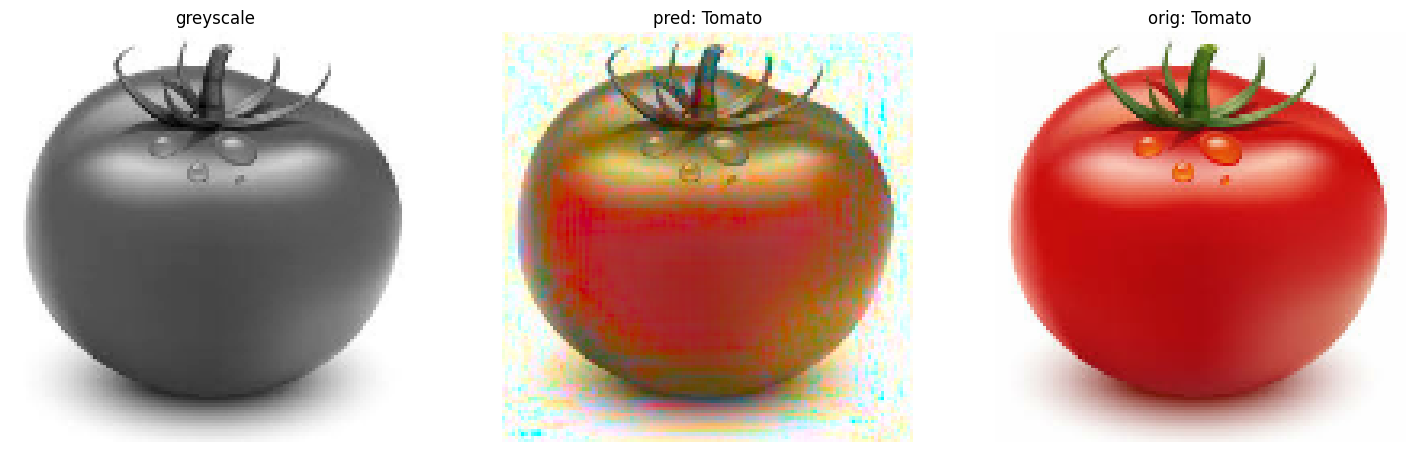

In [ ]:
for data in tqdm(test_data, position=0, leave=True):
    predicted_color = only_colorization.test_step(data)

#
    if random.random() < 1:
        visualize(predicted_color[0], data[1][0], data)